In [289]:
import os
import pandas as pd
import numpy as np
import six
import xarray as xr
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from matplotlib import dates

from stompy import utils
from stompy import filters
from stompy.io.local import noaa_coops
from stompy.model.suntans import sun_driver
from stompy import xr_utils, xr_transect
from stompy.grid import unstructured_grid
from stompy.plot import plot_utils
import stompy.plot.cmap as scmap
from stompy.spatial import field, proj_utils 
from stompy.model import data_comparison
%matplotlib notebook

In [211]:
turbo=scmap.load_gradient('turbo.cpt')

In [246]:
six.moves.reload_module(xr_transect)
six.moves.reload_module(sun_driver)

<module 'stompy.model.suntans.sun_driver' from '/home/rusty/src/stompy/stompy/model/suntans/sun_driver.py'>

In [295]:
six.moves.reload_module(sun_driver)
models=[
    #sun_driver.SuntansModel.load("runs/snubby_cfg003_20180403"),
    #sun_driver.SuntansModel.load("runs/steady005_20180401"),
    #sun_driver.SuntansModel.load("runs/cfg006_20180401"),   
    #sun_driver.SuntansModel.load("runs/steady007_20180401"),
    sun_driver.SuntansModel.load("runs/steady008_20180401"),
    sun_driver.SuntansModel.load("runs/cfg007_20180409"),
    sun_driver.SuntansModel.load("/opt2/san_joaquin/cfg008/cfg008_20180409")
]

for m in models:
    m.projection="EPSG:26910"    
    if len(models)>1:
        m.label=os.path.basename(m.run_dir)
    else:
        m.label='Model'

fig_dir=os.path.join(models[-1].run_dir,'figs-20191121')
os.path.exists(fig_dir) or os.makedirs(fig_dir)

In [291]:
obs_tran=xr.open_dataset("../../field/adcp/040518_BT/040518_5BTref-avg.nc")
obs_tran['eta']=0*obs_tran.depth_m
obs_tran.attrs['label']='2018_05'
transect=obs_tran

# Smooth the observations

Ulp_lat=filters.lowpass_fir(transect.U.values,winsize=10,axis=0)
Ulp_lat_vert=filters.lowpass_fir(Ulp_lat,winsize=10,axis=1)
transect.U.values[:]=Ulp_lat_vert

xr_transect.add_rozovski(transect)

In [298]:
def extract_to_match_obs(obs_tran,model,time=None):
    chain_interval=(model.chain_stop() - model.chain_start())
    steady=chain_interval<np.timedelta64(1,'D')
    if steady:
        t=-1 # choose the last step
    else:
        t=obs_tran.time.values
        if time is not None:
            t=time
    
    print(f"Extracting transect for time {t}")
    transect=model.extract_transect(xy=np.c_[obs_tran.x_sample,obs_tran.y_sample],
                                    dx=5,time=t)
    model.adjust_transect_for_dzmin_surface(transect,update_vars=['U','Ve','Vn'],
                                            dzmin_surf=0.25)
    offset=np.nanmean(transect.eta.values)
    xr_transect.shift_vertical(transect,-offset)
    transect['depth_m']=transect['dv']
    transect.attrs['label']=model.label
    xr_transect.add_rozovski(transect)
    return transect

In [299]:
mod_trans=[extract_to_match_obs(obs_tran,model)
           for model in models]

Extracting transect for time -1


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000


INFO:root:extract_transect: chain back


Extracting transect for time 2018-04-05T12:00:24.000000000


In [300]:
all_trans=[obs_tran]+mod_trans

obs_tran_fill=xr_transect.extrapolate_vertical(obs_tran,
                                              [ ('Uroz',dict(roz=0),'linear','constant'),
                                                ('Uroz',dict(roz=1),'linear','constant'),
                                                ('U',dict(xy=0),'linear','constant'),
                                                ('U',dict(xy=1),'linear','constant')],
                                              eta=0,z_bed='z_bed')
all_trans_fill=[obs_tran_fill]+mod_trans

In [301]:
# Report flows:
for tran in all_trans_fill:
    print(f"Transect {tran.label}")
    Q=xr_transect.Qleft(tran)
    print(f"{tran.label:20}: Q={Q:.3f}")
    
    # Is there a difference in length?
    z_dz,u,d_sample=xr.broadcast(tran.z_dz,tran.U.isel(xy=0),tran.d_sample)
    z_dz=z_dz.copy()
    z_dz.values[np.isnan(u)]=0.0
    valid=np.abs(z_dz.sum(dim='layer').values)>0.01
    print(f"{valid.sum()} of {len(valid)} water columns are wet")
    print(f"d_sample range: {d_sample.values.min()} – {d_sample.values.max()}")
    print(f"Time: {tran.time.values}")
    print()

# 

Transect 2018_05
2018_05             : Q=216.232
171 of 171 water columns are wet
d_sample range: 0.0 – 109.73402541349496
Time: 2018-04-05T12:00:24.000000000

Transect steady008_20180401
steady008_20180401  : Q=219.741
171 of 171 water columns are wet
d_sample range: 0.0 – 109.73402541416603
Time: 2018-04-01T04:00:00.000000000

Transect cfg007_20180409
cfg007_20180409     : Q=244.793
171 of 171 water columns are wet
d_sample range: 0.0 – 109.73402541416603
Time: 2018-04-05T12:00:00.000000000

Transect cfg008_20180409
cfg008_20180409     : Q=244.721
171 of 171 water columns are wet
d_sample range: 0.0 – 109.73402541416603
Time: 2018-04-05T12:00:00.000000000



<IPython.core.display.Javascript object>


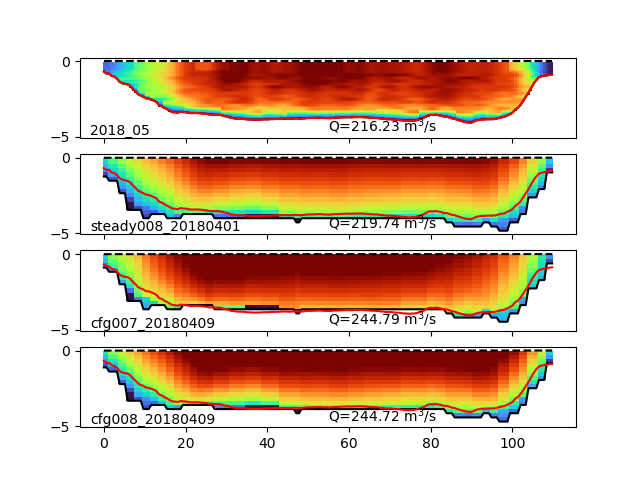

[None, None, None, None]

In [302]:
def plot_uroz(tran,ax):
    coll=xr_transect.plot_scalar(tran,tran.Uroz.sel(roz='downstream'),ax=ax,
                                 cmap=turbo)
    ax.plot(tran.d_sample, tran.eta,'k--',label='surface')
    ax.plot(tran.d_sample,-tran.depth_m,'k-',label='bed')
    return coll


fig,axs=plt.subplots(len(all_trans),1,sharex=True,sharey=True)

colls=[]
for tran,ax in zip(all_trans_fill,axs):
    coll=plot_uroz(tran,ax)
    colls.append(coll)
    ax.text(0.02,0.04,tran.attrs['label'],transform=ax.transAxes)
    if tran is not obs_tran:
        ax.plot(obs_tran.d_sample,-obs_tran.depth_m,'r-',label='Obs. bed')
    if 1: # calc/show flow
        Q=xr_transect.Qleft(tran)
        ax.text(0.5,0.02,f"Q={Q:.2f} m$^3$/s",transform=ax.transAxes,
               va='bottom')

plt.setp(colls,clim=[0.0,0.8])

<IPython.core.display.Javascript object>


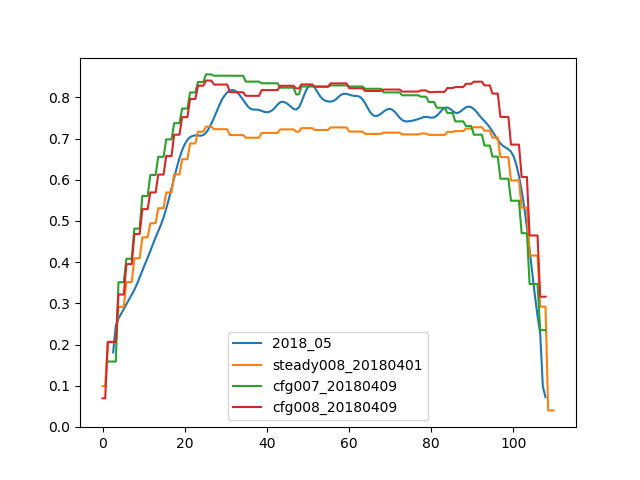

In [303]:
# Pull out velocity 1m down
new_z=np.array([-0.95,-1.05])

fig,ax=plt.subplots(1,1)

for tran in all_trans:    
    tran_slice=xr_transect.resample_z(tran,new_z,new_z_positive='up')
    Uslice=xr_transect.depth_avg(tran_slice,'Uroz')
    ax.plot(tran_slice.d_sample,Uslice.sel(roz='downstream'),label=tran.label)
ax.legend()
  

In [ ]:
# Now the long run is a little high, and its shape is not quite
# as good as steady008.


In [96]:
for tran in all_trans:
    if tran.z_ctr.attrs.get('positive','up')=='down':
        assert tran.z_ctr.mean()>0
        assert np.nanmean(np.diff(tran.z_ctr)) > 0
    else:
        assert tran.z_ctr.mean()<0
        assert np.nanmean(np.diff(tran.z_ctr))<0
    